<a href="https://colab.research.google.com/github/ranitha84/gesture_recognition/blob/main/Gesture_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Project_data.zip

Streaming output truncated to the last 5000 lines.
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00001.png  
 extracting: Project_data/t

In [3]:
!pip install scipy==1.1.0


     |████████████████████████████████| 31.2MB 110kB/s 
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [4]:
import numpy as np
import os
import datetime
import cv2


In [5]:
np.random.seed(30)
import random as rn
from keras import backend as K
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D,MaxPooling2D,ZeroPadding3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers


rn.seed(30)
tf.random.set_seed(30)

In [6]:
drive_path = '/content/Project_data'

train_doc = np.random.permutation(open(drive_path+'/train.csv').readlines())
val_doc = np.random.permutation(open(drive_path+'/val.csv').readlines())

train_path = drive_path+'/train'
val_path = drive_path+'/val'

batch_size = 10

image_width = 100
image_height = 100

In [7]:

class AugmentedDataGenerator:

  def __init__(self, width=image_width, height=image_height, frames=30, channels=3,number_samples=20,num_classes=5,  augment=False):
    self.width= width
    self.height = height
    self.frames = 30
    self.channels = channels
    self.augment = augment
    self.number_samples = number_samples
    self.num_classes = num_classes

  def yield_batches(self,source_path,t,batch,batch_size,img_idx,remaining_seq=0):
      seq_len = remaining_seq if remaining_seq else batch_size
      
      batch_data = np.zeros((seq_len,len(img_idx),self.height,self.width,self.channels)) 
      batch_labels = np.zeros((seq_len,self.num_classes)) 

      if (self.augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.height,self.width,self.channels))

      
      for folder in range(seq_len): 
          imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
          for idx,item in enumerate(img_idx): 
              image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_COLOR)
              image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
              image_resized=cv2.resize(image, (self.height,self.width), interpolation = cv2.INTER_AREA)
          

              batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
              batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
              batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
          
              if (self.augment):
                  shifted = cv2.warpAffine(image, 
                                            np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                          (image.shape[1], image.shape[0]))
                  
                  gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                  x0, y0 = np.argwhere(gray > 0).min(axis=0)
                  x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                  
                  cropped=shifted[x0:x1,y0:y1,:]
                  
                  image_resized=cv2.resize(image, (self.height,self.width), interpolation = cv2.INTER_AREA)
                  
                  
                  batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                  batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                  batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
              
          
          batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
          

      if (self.augment):
          batch_data=np.concatenate([batch_data,batch_data_aug])
          batch_labels=np.concatenate([batch_labels,batch_labels])

      
      return (batch_data,batch_labels)

  def generator(self, source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0,self.frames-1,self.number_samples)).astype(int)
    batch_size=batch_size
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size
        remaining_seq = len(t)%batch_size

        for batch in range(num_batches): 
            batch_data, batch_labels= self.yield_batches(source_path,t,batch,batch_size,img_idx)
            yield batch_data, batch_labels 

        
        if (len(t)%batch_size):
            batch_data, batch_labels= self.yield_batches(source_path,t,num_batches,batch_size,img_idx,remaining_seq)
            yield batch_data, batch_labels 
    

In [8]:
import matplotlib.pyplot as plt # for plotting


def plot_accuracy(history):
  plt.figure(figsize=(16,6))
  plt.subplot(1,2,1)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend(['train', 'validation'])

  plt.subplot(1,2,2)
  plt.plot(history.history['categorical_accuracy'])
  plt.plot(history.history['val_categorical_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend(['train', 'validation'])

  plt.show() 

In [9]:
def train_model( model, batch_size, num_epochs, train_generator, val_generator,learning_rate=0.01):
    curr_dt_time = datetime.datetime.now()
    num_train_sequences = len(train_doc)
    print('# training sequences =', num_train_sequences)
    num_val_sequences = len(val_doc)
    print('# validation sequences =', num_val_sequences)
    print ('# epochs =', num_epochs)

    print('Number of epochs {}'.format(num_epochs))
    print('Batch Size {}'.format(batch_size))
    print('Current Date time {}'.format(curr_dt_time))

    # Defining call back lists

    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}--{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 save_weights_only=False, 
                                 mode='auto')

    LR = ReduceLROnPlateau(monitor='val_loss',factor=0.2, patience=4, verbose=1)

    callbacks_list = [checkpoint, LR]

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())
   
    if (num_train_sequences%batch_size) == 0:
      steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    
    history = model.fit(train_generator, 
              steps_per_epoch=steps_per_epoch, 
              epochs=num_epochs, 
              verbose=1, 
              callbacks=callbacks_list, 
              validation_data=val_generator, 
              validation_steps=validation_steps, 
              class_weight=None, 
              initial_epoch=0,
              workers=1)
    plot_accuracy(history)
    K.clear_session()

In [10]:
class ModelGenerator():

  def __init__(self,input_shape=(30, image_height,image_width,3), num_classes=5):
    self.input_shape= input_shape
    self.num_classes = num_classes

  def model_cv3D(self,dropout=0.25):

      model = Sequential()
      model.add(Conv3D(16, (3, 3, 3), padding='same',
                input_shape=self.input_shape))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))

      model.add(Conv3D(32, (2, 2, 2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))

      model.add(Conv3D(64, (2, 2, 2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))

      model.add(Conv3D(128, (2, 2, 2), padding='same'))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      model.add(MaxPooling3D(pool_size=(2, 2, 2)))

      model.add(Flatten())
      model.add(Dense(128,activation='relu'))
      model.add(BatchNormalization())
      model.add(Dropout(dropout))

      model.add(Dense(64,activation='relu'))
      model.add(BatchNormalization())
      model.add(Dropout(dropout))


      model.add(Dense(self.num_classes,activation='softmax'))

      return model

# training sequences = 663
# validation sequences = 100
# epochs = 3
Number of epochs 3
Batch Size 20
Current Date time 2021-02-28 16:16:25.089200
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 100, 100, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 20, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 50, 50, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 50, 50, 32)    4128      
_________________________________________________________________
activation_1 (Activation)    (None, 10, 5

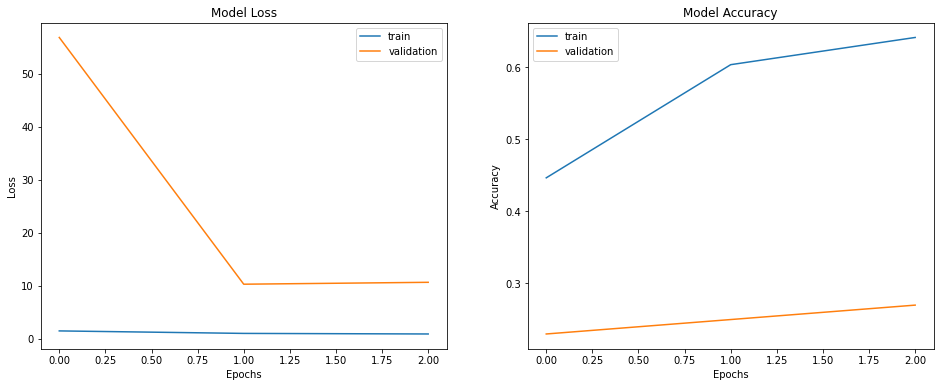

In [11]:
train_gen = AugmentedDataGenerator()
val_gen = AugmentedDataGenerator()

batch_size = 20
num_epochs =3

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(20,image_height,image_width,3))

model = model_generator.model_cv3D()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)

# training sequences = 663
# validation sequences = 100
# epochs = 2
Number of epochs 2
Batch Size 30
Current Date time 2021-02-28 16:18:13.136325
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_1 (Activation)    (None, 8, 50

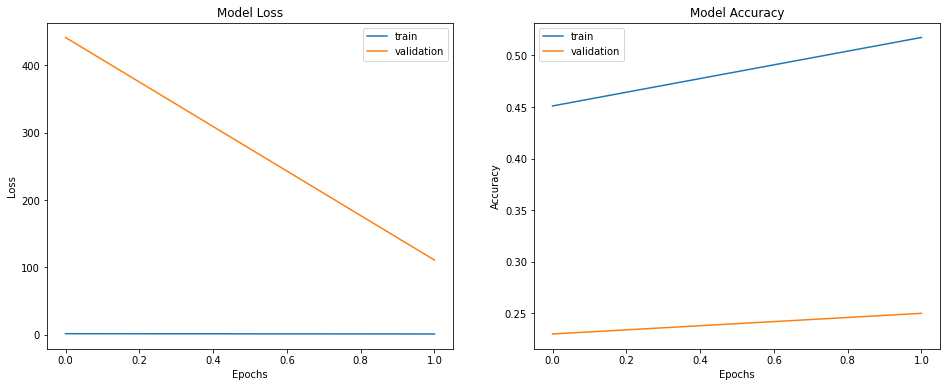

In [12]:
batch_size = 30
num_epochs =2
frames_sample=16

train_gen = AugmentedDataGenerator(number_samples=frames_sample)
val_gen = AugmentedDataGenerator(number_samples=frames_sample)


train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(frames_sample,image_height,image_width,3))

model = model_generator.model_cv3D()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)

# training sequences = 663
# validation sequences = 100
# epochs = 15
Number of epochs 15
Batch Size 40
Current Date time 2021-02-28 16:19:10.092858
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 100, 100, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 20, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 50, 50, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 50, 50, 32)    4128      
_________________________________________________________________
activation_1 (Activation)    (None, 10,

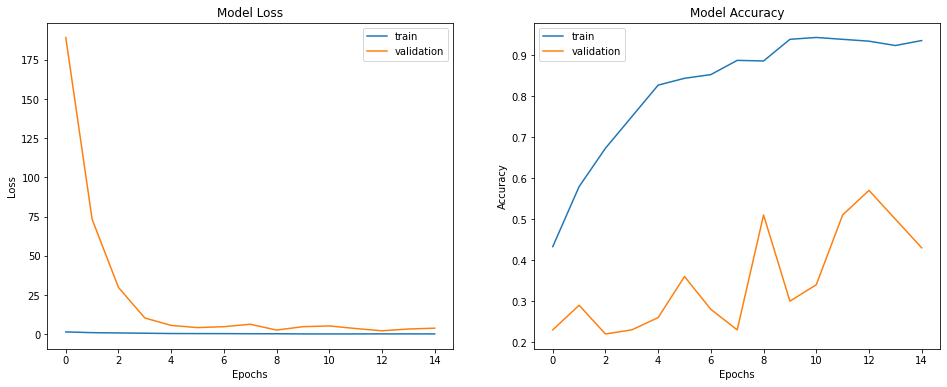

In [13]:
frames_sample=20
batch_size=40
num_epochs=15

train_gen = AugmentedDataGenerator(number_samples=frames_sample)
val_gen = AugmentedDataGenerator(number_samples=frames_sample)


train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(frames_sample,image_height,image_width,3))

model = model_generator.model_cv3D()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)

# training sequences = 663
# validation sequences = 100
# epochs = 25
Number of epochs 25
Batch Size 40
Current Date time 2021-02-28 16:29:29.734672
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_8 (Activation)    (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 10, 60, 60, 32)    4128      
_________________________________________________________________
activation_9 (Activation)    (None, 1

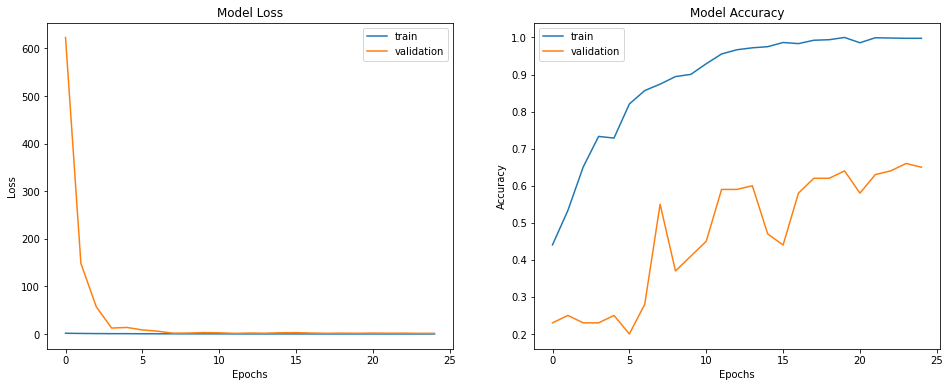

In [16]:
frames_sample=20
batch_size=40
num_epochs=25
image_height=120
image_width=120

train_gen = AugmentedDataGenerator(width=image_width, height=image_height,number_samples=frames_sample,augment=True)
val_gen = AugmentedDataGenerator(number_samples=frames_sample,width=image_width, height=image_height)


train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

model_generator = ModelGenerator(input_shape=(frames_sample,image_height,image_width,3))

model = model_generator.model_cv3D()

train_model(model=model,batch_size=batch_size,num_epochs=num_epochs,train_generator=train_generator,val_generator=val_generator)